In [2]:
!pip install quantiq
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

[Ensemble 0] Epoch 1/5 Batch 0 Loss: 16.6749
[Ensemble 0] Epoch 1/5 Batch 1 Loss: 12.3977
[Ensemble 0] Epoch 1/5 Batch 2 Loss: 10.7371
[Ensemble 0] Epoch 1/5 Batch 3 Loss: 6.1651
[Ensemble 0] Epoch 1/5 Batch 4 Loss: 4.3541
[Ensemble 0] Epoch 1/5 Batch 5 Loss: 4.5853
[Ensemble 0] Epoch 1/5 Batch 6 Loss: 4.6145
[Ensemble 0] Epoch 2/5 Batch 0 Loss: 4.2850
[Ensemble 0] Epoch 2/5 Batch 1 Loss: 3.7506
[Ensemble 0] Epoch 2/5 Batch 2 Loss: 3.9927
[Ensemble 0] Epoch 2/5 Batch 3 Loss: 3.6566
[Ensemble 0] Epoch 2/5 Batch 4 Loss: 4.2936
[Ensemble 0] Epoch 2/5 Batch 5 Loss: 3.5747
[Ensemble 0] Epoch 2/5 Batch 6 Loss: 4.0766
[Ensemble 0] Epoch 3/5 Batch 0 Loss: 3.7326
[Ensemble 0] Epoch 3/5 Batch 1 Loss: 3.6018
[Ensemble 0] Epoch 3/5 Batch 2 Loss: 3.2805
[Ensemble 0] Epoch 3/5 Batch 3 Loss: 3.5163
[Ensemble 0] Epoch 3/5 Batch 4 Loss: 3.3803
[Ensemble 0] Epoch 3/5 Batch 5 Loss: 3.5161
[Ensemble 0] Epoch 3/5 Batch 6 Loss: 3.3537
[Ensemble 0] Epoch 4/5 Batch 0 Loss: 2.9979
[Ensemble 0] Epoch 4/5 Batch 

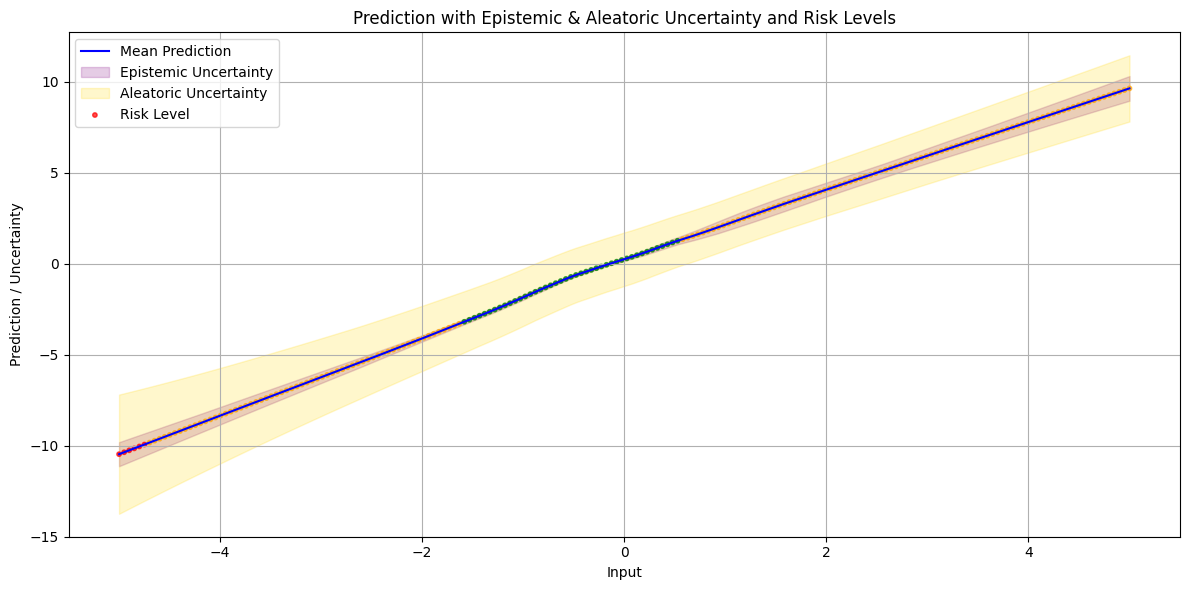

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from quantiq import SmartEnsemble

# Define a toy regression model that returns (mean, logvar)
class ToyRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.base = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 2)  # Output: mean and logvar
        )

    def forward(self, x):
        out = self.base(x)
        mean = out[:, 0:1]
        logvar = out[:, 1:2]
        return mean, logvar

# Generate synthetic 1D regression data: y = 2x + noise
torch.manual_seed(0)
X = torch.linspace(-5, 5, 200).unsqueeze(1)
y = 2 * X + torch.randn_like(X) * 2

# Wrap in DataLoader
train_loader = DataLoader(TensorDataset(X, y), batch_size=32, shuffle=True)

# Define the ensemble
ensemble = SmartEnsemble(model_fn=ToyRegressor, num_models=3, task="regression")

# Train
ensemble.fit(
    dataloader=train_loader,
    optimizer_fn=lambda m: torch.optim.Adam(m.parameters(), lr=0.01),
    epochs=5,
    log_interval=1,
    clip_grad_norm=1.0
)

# Predict on new points
test_x = torch.tensor([[-2.0], [0.0], [2.0], [10.0]])  # Last one is OOD
mean, epi, alea = ensemble.predict(test_x)

print("Predictions:")
for i, x in enumerate(test_x):
    print(f"x = {x.item():5.2f} | mean = {mean[i].item():.2f} ± (epi={epi[i].item():.2f}, alea={alea[i].item():.2f})")

# Calibrate thresholds and test risk scoring
ensemble.calibrate_uncertainty_thresholds(train_loader)
for i in range(len(test_x)):
    label = ensemble.score_risk(epi[i], alea[i])
    print(f"Risk label for x = {test_x[i].item():5.2f}: {label}")

# Optional: visualize
ensemble.visualize_uncertainty()